In [3]:
# !pip install networkx
# !pip install matplotlib==2.2.3.

zsh:1: /usr/local/bin/pip: bad interpreter: /usr/local/opt/python/bin/python3.7: no such file or directory


In [2]:
import pandas as pd
import networkx as nx

data_folder = "../../../data"

In [4]:
nx.__version__

'2.3'

In [5]:
df_op = pd.read_csv(f'{data_folder}/resources/openpredict-omim-drug.csv')

In [6]:
df_op = df_op.rename(columns={'omimid': 'disease_id', 'drugid': 'drug_id'})

In [7]:
df_op.disease_id = df_op.disease_id.astype(str)


In [8]:
indications_dict = set()
for i, row in df_op.iterrows():
    #row['DB_ID'], row['DO_ID']
    pair = (str(row['drug_id']), str(row['disease_id']))
    indications_dict.add(pair)
len(indications_dict)


1966

In [8]:

#!pip install gensim

In [9]:
from gensim.models import KeyedVectors


In [10]:
drug_fp_vectors = KeyedVectors.load_word2vec_format(
    f'{data_folder}/embedding/drugs_fp_embed.txt', binary=False)
disease_hp_vectors = KeyedVectors.load_word2vec_format(
    f'{data_folder}/embedding/disease_hp_embed.txt', binary=False)


In [23]:
# openpredict:most_similar('DB00570', 10)
# path generation
def generate_paths_for_apair(drug, disease, drug_emb_vectors, disease_emb_vectors):
    g = nx.Graph()
    #g.add_edge(DRUGB[dr], OMIM[ds], weight=1)
    similarDrugs = drug_emb_vectors.most_similar(drug, topn=100)
    #print (similarDrugs)
    g.add_node("DrugBank:"+drug, id="DrugBank:"+drug,
               name="fake", categories=["biolink:Drug"])
    for dr, sim in similarDrugs:
        #print(dr, ' ', drug, 1-sim)
        #g.add_edge(dr, drug, weight=1-sim)

        g.add_node("DrugBank:"+dr, id="DrugBank:"+dr,
                   name="fake", categories=["biolink:Drug"])
        g.add_edge("DrugBank:"+dr, "DrugBank:"+drug, id="DrugBank:"+dr+"_DrugBank: "+drug,
                   predicate="biolink:similar_to", subject="DrugBank:"+dr, object="DrugBank:"+drug,  weight=1-sim, attributes={"description": "score",
                                                               "attribute_type_id": "EDAM:data_1772",
                                                               "value": 1+(1-sim)
                                                               })
    g.add_node("OMIM:"+disease, id="OMIM:"+disease,
               name="fake", categories=["biolink:Disease"])
               
    similarDiseases = disease_emb_vectors.most_similar(disease, topn=100)
    for ds, sim in similarDiseases:
        #print(ds, ' ', disease)
        #g.add_edge(ds, disease, weight=1-sim)
        g.add_node("OMIM:"+ds, id="OMIM:"+ds,
                   name="fake", categories=["biolink:Disease"])
        g.add_edge("OMIM:"+ds, "OMIM:"+disease,
                   id="OMIM:" + ds+"_OMIM:"+disease, predicate="biolink:similar_to", subject="OMIM:"+ds, object="OMIM:"+disease, weight=1-sim, attributes={"description": "score",
                                                                                                 "attribute_type_id": "EDAM:data_1772",
                                                                                                 "value": 1+(1-sim)
                                                                                                 })
                                                                                                 


    for (dr, ds) in indications_dict:
        if "DrugBank:"+dr in g.nodes() and "OMIM:"+ds in g.nodes():
            #print(dr, ds, 1)
            #g.add_edge(dr, ds, weight=1)
            g.add_edge("DrugBank:"+dr, "OMIM:"+ds, id="DrugBank:" +
                       dr+"_OMIM:"+ds, predicate="biolink:treats", subject="DrugBank:"+dr, object="OMIM:"+ds,  weight=1.0, attributes={"description": "score",
                                                                               "attribute_type_id": "EDAM:data_1772",
                                                                               "value": "1.0"
                                                                               })
    return g


In [24]:
g1 = generate_paths_for_apair(
    'DB00915', '104300', drug_fp_vectors, disease_hp_vectors)


In [17]:
print("numbee of nodes",g1.number_of_nodes())
print("numbee of nodes", g1.number_of_edges())


numbee of nodes 202
numbee of nodes 333


In [68]:
g1.node['OMIM:104300']


{'id': 'OMIM:104300', 'name': 'fake', 'categories': ['biolink:Disease']}

In [69]:
length, path = nx.single_source_dijkstra(g1, 'DrugBank:DB00915', 'OMIM:104300')


In [20]:
#length, path = nx.single_source_dijkstra(g1, 'DrugBank:DB00570', 'OMIM:236000')
path_weight = {}
for path in nx.all_simple_paths(g1, 'DrugBank:DB00915', 'OMIM:104300', cutoff=4):
    #print (path)
    #break
    dpath = 0
    for i in range(len(path)-1):
        #print(g1[path[i]][path[i+1]])
        dpath += g1[path[i]][path[i+1]]['weight']
    path_weight[str(path)] = dpath


In [21]:
path_weight_dict = sorted(path_weight.items(), key=lambda x: x[1], )

In [22]:
path_weight_dict[:10]


[("['DrugBank:DB00915', 'DrugBank:DB00843', 'OMIM:104300']",
  1.1941457986831665),
 ("['DrugBank:DB00915', 'DrugBank:DB00909', 'OMIM:608105', 'OMIM:104300']",
  1.1944136023521423),
 ("['DrugBank:DB00915', 'DrugBank:DB00989', 'OMIM:104300']",
  1.2105293273925781),
 ("['DrugBank:DB00915', 'DrugBank:DB01043', 'OMIM:104300']", 1.21715247631073),
 ("['DrugBank:DB00915', 'DrugBank:DB00996', 'OMIM:608105', 'OMIM:104300']",
  1.2240398526191711),
 ("['DrugBank:DB00915', 'DrugBank:DB00907', 'OMIM:608088', 'OMIM:104300']",
  1.2435468435287476),
 ("['DrugBank:DB00915', 'DrugBank:DB00927', 'OMIM:190310', 'OMIM:104300']",
  1.2508054971694946),
 ("['DrugBank:DB00915', 'DrugBank:DB00868', 'OMIM:608088', 'OMIM:104300']",
  1.2542904615402222),
 ("['DrugBank:DB00915', 'DrugBank:DB00794', 'OMIM:608105', 'OMIM:104300']",
  1.2545140385627747),
 ("['DrugBank:DB00915', 'DrugBank:DB00863', 'OMIM:190310', 'OMIM:104300']",
  1.262675166130066)]

In [73]:
import ast
G = nx.Graph()
for p, s in path_weight_dict[:5]:
    path = ast.literal_eval(p)
    print(path, s)
    for i in range(len(path)-1):
        #print(path[i])
        s_node_name = path[i]
        t_node_name = path[i+1]
        edge_data = g1[s_node_name][t_node_name]
        #print(node_name)
        G.add_node(s_node_name, g1.node[s_node_name])
        G.add_node(t_node_name, g1.node[t_node_name])
        G.add_edge(s_node_name, t_node_name, edge_data)


['DrugBank:DB00915', 'DrugBank:DB00843', 'OMIM:104300'] 1.1941457986831665
['DrugBank:DB00915', 'DrugBank:DB00909', 'OMIM:608105', 'OMIM:104300'] 1.1944135427474976
['DrugBank:DB00915', 'DrugBank:DB00989', 'OMIM:104300'] 1.2105293273925781
['DrugBank:DB00915', 'DrugBank:DB01043', 'OMIM:104300'] 1.2171525359153748
['DrugBank:DB00915', 'DrugBank:DB00996', 'OMIM:608105', 'OMIM:104300'] 1.2240397334098816


In [ ]:
import ast


def generate_explanation(drug, disease, drug_fp_vectors, disease_hp_vectors, topK):
    #-> Path generation, add similar_to relation between query drug and disease
    #-> add known treats relations if any drug-disease pair in the graph has a treats relation
    g1 = generate_paths_for_apair(
        drug, disease, drug_fp_vectors, disease_hp_vectors)

    # Iterate over all simple paths
    # assign a weight to each path by summing their weights (for similar_to weight is 1-similarity, for treats, weight is 1)
    path_weight = {}
    for path in nx.all_simple_paths(g1, drug, disease , cutoff=4):
        dpath = 0
        for i in range(len(path)-1):
            #print(g1[path[i]][path[i+1]])
            dpath += g1[path[i]][path[i+1]]['weight']
        path_weight[str(path)] = dpath
    # rank the paths and take only top-K paths
    path_weight_dict = sorted(path_weight.items(), key=lambda x: x[1], )
    # create a final graph by merging the top-K paths
    G = nx.Graph()
    for p, s in path_weight_dict[:topK]:
        path = ast.literal_eval(p)
        print(path, s)
        for i in range(len(path)-1):
            #print(path[i])
            s_node_name = path[i]
            t_node_name = path[i+1]
            edge_data = g1[s_node_name][t_node_name]
            #print(node_name)
            G.add_node(s_node_name, g1.node[s_node_name])
            G.add_node(t_node_name, g1.node[t_node_name])
            G.add_edge(s_node_name, t_node_name, edge_data)

    return G


In [37]:
G.number_of_edges()

11

In [38]:
G.number_of_nodes()


8

In [40]:
#G['DrugBank:DB00570']['OMIM:236000']


In [41]:
graph_json ={}

In [42]:

graph_json['nodes'] = list()
for node in G.nodes():
    #print (node)
    print(G.node[node])
    graph_json['nodes'].append(G.node[node])


{'id': 'DrugBank:DB00915', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'DrugBank:DB00843', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'OMIM:104300', 'name': 'fake', 'categories': ['biolink:Disease']}
{'id': 'DrugBank:DB00909', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'OMIM:608105', 'name': 'fake', 'categories': ['biolink:Disease']}
{'id': 'DrugBank:DB00989', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'DrugBank:DB01043', 'name': 'fake', 'categories': ['biolink:Drug']}
{'id': 'DrugBank:DB00996', 'name': 'fake', 'categories': ['biolink:Drug']}


In [43]:

graph_json['edges']=list()
for edge in G.edges():
    #print (edge)
    #print(G[edge[0]][edge[1]], type(G[edge[0]][edge[1]]))
    graph_json['edges'].append(G[edge[0]][edge[1]])


In [44]:
graph_json

{'nodes': [{'id': 'DrugBank:DB00915',
   'name': 'fake',
   'categories': ['biolink:Drug']},
  {'id': 'DrugBank:DB00843', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'OMIM:104300', 'name': 'fake', 'categories': ['biolink:Disease']},
  {'id': 'DrugBank:DB00909', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'OMIM:608105', 'name': 'fake', 'categories': ['biolink:Disease']},
  {'id': 'DrugBank:DB00989', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'DrugBank:DB01043', 'name': 'fake', 'categories': ['biolink:Drug']},
  {'id': 'DrugBank:DB00996', 'name': 'fake', 'categories': ['biolink:Drug']}],
 'edges': [{'id': 'DrugBank:DB00843_DrugBank: DB00915',
   'predicate': 'biolink:similar_to',
   'subject': 'DrugBank:DB00843',
   'object': 'DrugBank:DB00915',
   'weight': 0.1941457986831665,
   'attributes': {'description': 'score',
    'attribute_type_id': 'EDAM:data_1772',
    'value': 0.1941457986831665}},
  {'id': 'DrugBank:DB00909_DrugBank: DB00915',
   

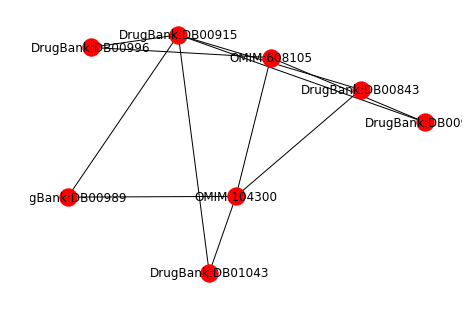

In [45]:
import matplotlib.pyplot as plt
#G = nx.dodecahedral_graph()
#nx.draw(G)  # networkx draw()
#plt.draw()  # pyplot draw()
plt.show()

options = {
    "font_size": 20,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 15,
}
#nx.draw(G, pos=nx.multipartite_layout(G), with_labels=True)
nx.draw(G, with_labels=True)
plt.draw()